# **Clustering**

El primer paso es realizar un análisis de segmentación para agrupar clientes o productos según características clave.

In [1]:
%load_ext autoreload
%autoreload 2


# -----------------------------------------------------------------------
import numpy as np
import pandas as pd


import warnings
warnings.filterwarnings('ignore')

import sys

sys.path.append("../")
from src import funciones_eda as fe
from src import soporte_clustering as sc
from src import funciones_encoding as fen
from src import funciones_outliers as fo
from src import funciones_estandarizacion as fes

pd.set_option("display.max_columns", None)

In [26]:
df = pd.read_csv("../datos/Global_Superstore.csv", encoding="latin1")
df.head(3)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Country,Postal Code,Market,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,32298,CA-2012-124891,31-07-2012,31-07-2012,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,United States,10024.0,US,East,TEC-AC-10003033,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.57,Critical
1,26341,IN-2013-77878,05-02-2013,07-02-2013,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,Australia,NaN,APAC,Oceania,FUR-CH-10003950,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical
2,25330,IN-2013-71249,17-10-2013,18-10-2013,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,Australia,NaN,APAC,Oceania,TEC-PH-10004664,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.49,Medium


Observamos que no hay dupolicados y la única columna que tiene nulos es Postal Code:

In [27]:
print(f"Hay {df.duplicated().sum()} duplicados.")
df.isna().sum()

Hay 0 duplicados.


Row ID                0
Order ID              0
Order Date            0
Ship Date             0
Ship Mode             0
Customer ID           0
Customer Name         0
Segment               0
City                  0
State                 0
Country               0
Postal Code       41296
Market                0
Region                0
Product ID            0
Category              0
Sub-Category          0
Product Name          0
Sales                 0
Quantity              0
Discount              0
Profit                0
Shipping Cost         0
Order Priority        0
dtype: int64

Vamos a eliminar las columnas que no aportan valor a la hora de segmentar los clientes. Entre ellas la columna que consideramos más importante es `Profit` pues nosotros como empresa lo que vamos a intentar es segmentar a nuestros clientes en base al dinero que nos están generando como empresa.

In [28]:
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'City', 'State', 'Country',
       'Postal Code', 'Market', 'Region', 'Product ID', 'Category',
       'Sub-Category', 'Product Name', 'Sales', 'Quantity', 'Discount',
       'Profit', 'Shipping Cost', 'Order Priority'],
      dtype='object')

In [29]:
df_clustering = df[['Ship Mode', 'Market', 'Category', 'Sales', 'Quantity', 'Profit']]

In [30]:
fe.exploracion_dataframe(df_clustering)

El número de datos es 51290 y el de columnas es 6

 ..................... 

Los duplicados que tenemos en el conjunto de datos son: 4878

 ..................... 

Los nulos que tenemos en el conjunto de datos son:


,%_nulos



 ..................... 

Los tipos de las columnas son:


,tipo_dato
Ship Mode,object
Market,object
Category,object
Sales,float64
Quantity,int64
Profit,float64



 ..................... 



,count,mean,std,min,25%,50%,75%,max
Sales,51290.0,246.490581,487.565361,0.444,30.758625,85.053,251.0532,22638.480
Quantity,51290.0,3.476545,2.278766,1.000,2.000000,3.000,5.0000,14.000
Profit,51290.0,28.610982,174.340972,-6599.978,0.000000,9.240,36.8100,8399.976



 ..................... 

Los valores que tenemos para las columnas categóricas son: 
La columna SHIP MODE tiene las siguientes valore únicos:


,count
Ship Mode,
Standard Class,30775
Second Class,10309
First Class,7505
Same Day,2701


La columna MARKET tiene las siguientes valore únicos:


,count
Market,
APAC,11002
LATAM,10294
EU,10000
US,9994
EMEA,5029


La columna CATEGORY tiene las siguientes valore únicos:


,count
Category,
Office Supplies,31273
Technology,10141
Furniture,9876


Podemos observar que han aparecido duplicados debido a que hemos eliminado numerosas columnas, sin embargo, esos duplicados corresponden a datos reales por lo que los mantenemos. 

Vemos que tanto la media como mediana de las variables numéricas difieren bastante siendo en Sales 85 la mediana y 246 la media, lo que implica que hay alguno valores muy muy altos que distorsionan la media, lo mismo ocurre con Profit.

### 1. Visualizar numéricas y categóricas.

In [7]:
sop_clust = sc.Exploracion(df_clustering)

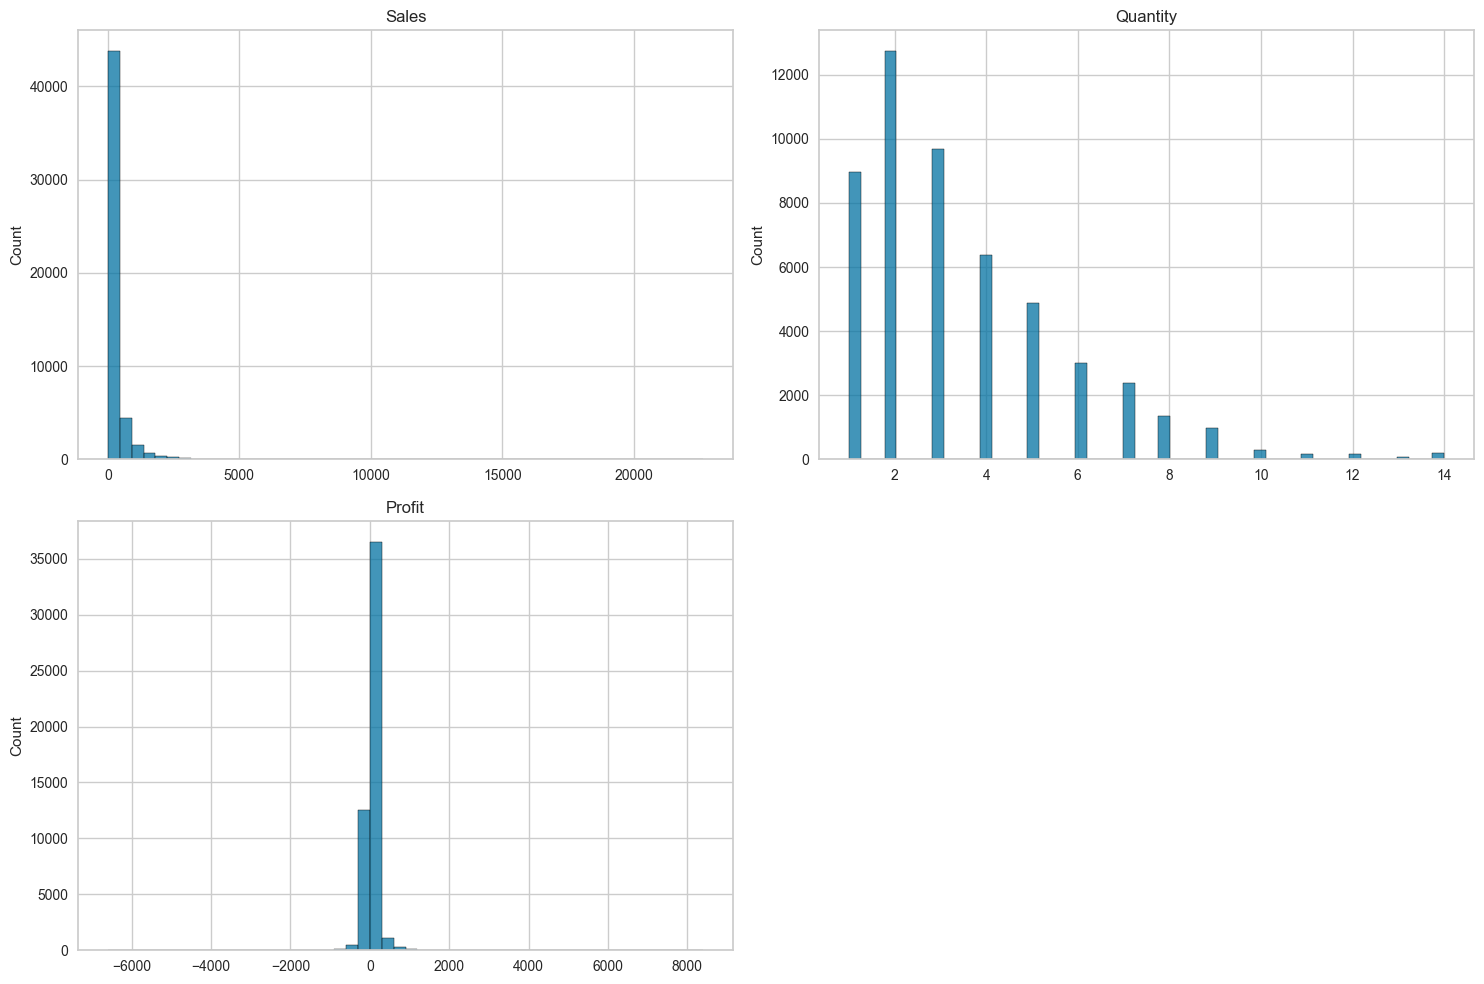

In [8]:
df_num, df_cat = fe.separar_df(df_clustering)
fe.plot_numericas(df_num)

Podemos observar gráficamente lo que acabamos de comentar sobre la media y la mediana y como hay valores donde hay muchísimo más peso que en otras haciendo que la media sea poco fiable.

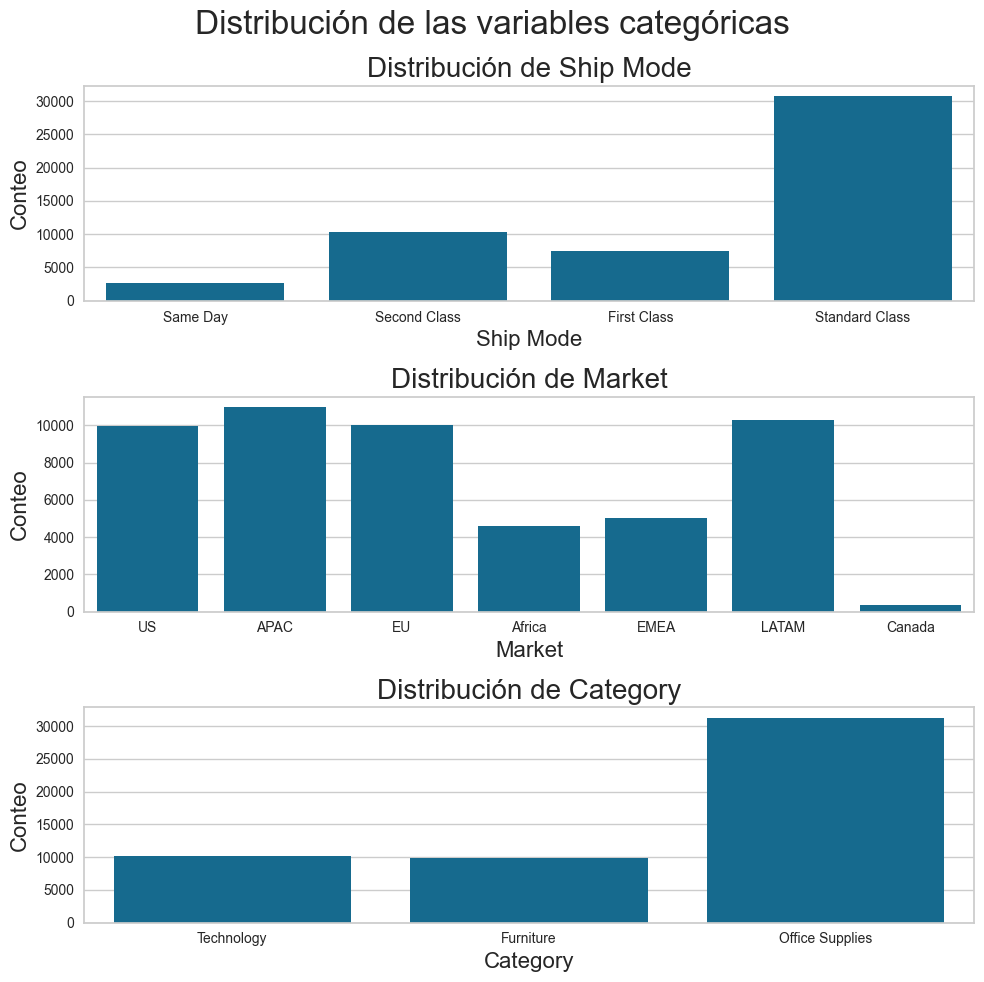

In [10]:
sop_clust.visualizar_categoricas(figsize=(10,10))

En cuanto a las variables categóricas podemos ver que en Segment la variable consumer es la dominante, en cuanto a paises claramente hay muchísimos más clientes de Estados Unidos que de otros paises lo que puede generarnos demasiados clusters debido a sus distintos hábitos de compra. En cuanto a Category la más vendidad es Office Supllies y en cuanto a Order Priority la más usada es medium seguida de high.

### 2. Correlación entre variables numéricas

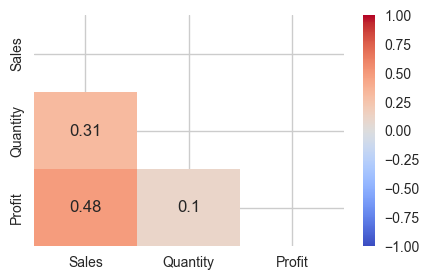

In [11]:
fe.heatmap_correlacion(df_clustering, figsize=(5,3))

La correlación entre Sales y Profit es mediana, de hecho estudiando los datos la categoría que más sales genera es la que menos profit da, no en todas es así, pero es una buena observación para entender porque la correlación no es más alta.

### 3. Outliers

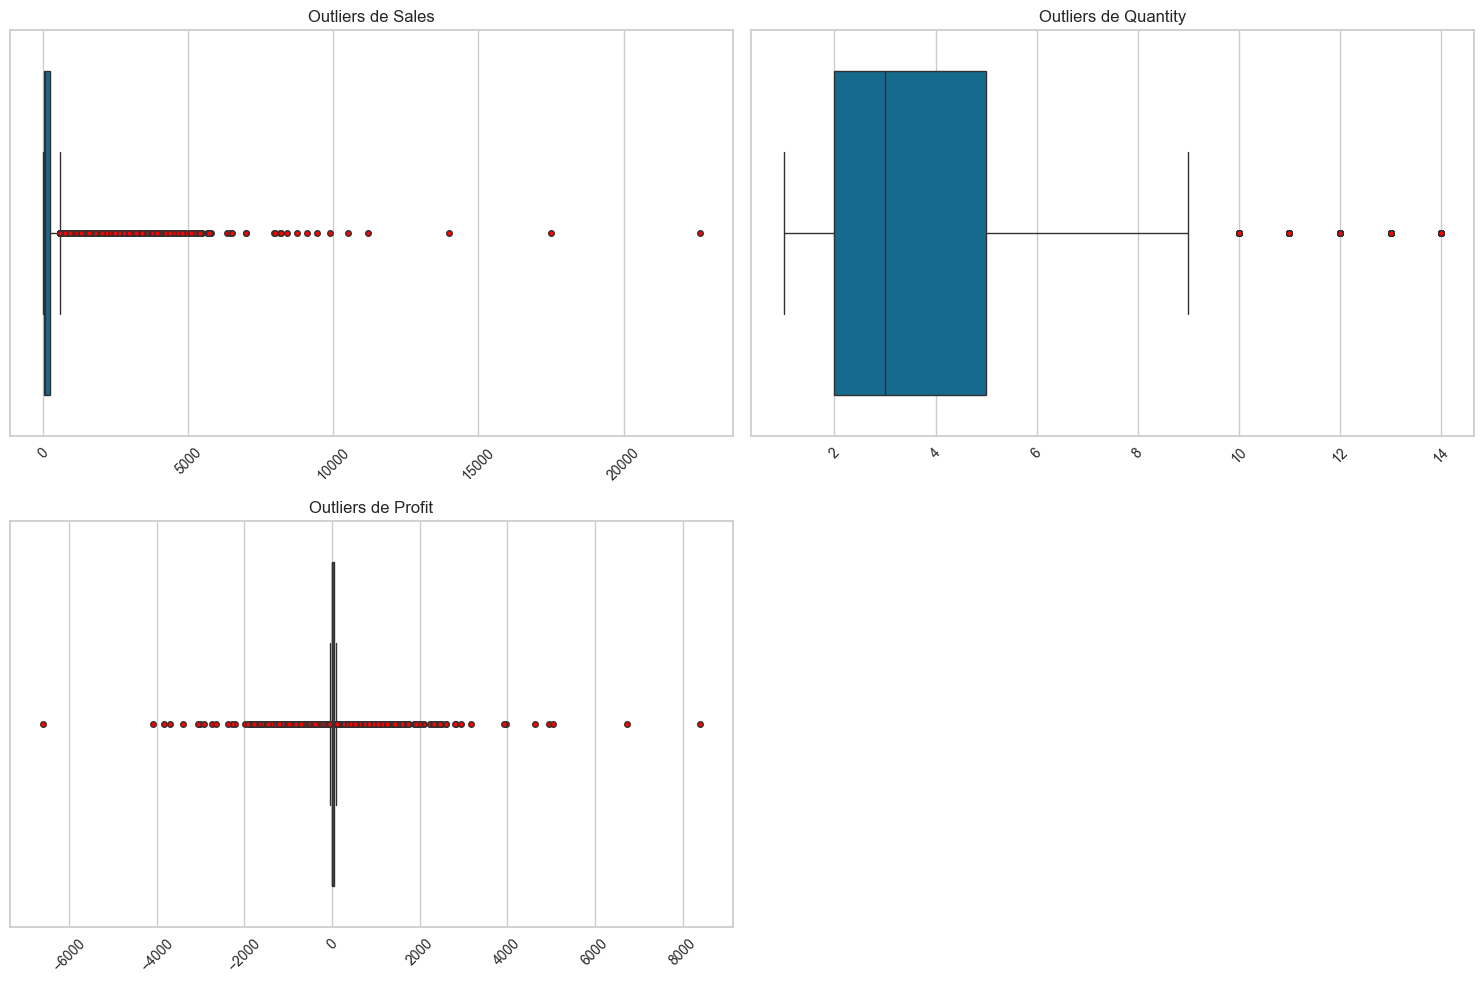

In [12]:
fe.detectar_outliers(df_clustering)

In [13]:
multi = fo.GestionOutliersMultivariados(df_clustering)
contaminacion = [0.01, 0.05, 0.1]
estimadores = [10, 100, 200]
cols = df_num.columns
vr = ""
df_outliers = multi.detectar_outliers_if(cols, vr, contaminacion, estimadores, False)

In [14]:
df_outliers["porcentaje_outliers"] = df_outliers.filter(like="outliers").apply(lambda x: round(sum(x==-1)/len(x),2), axis=1)

porcentaje = 0.6
df_outliers_porcentaje = df_outliers[df_outliers["porcentaje_outliers"]>porcentaje]
df_restante = df_outliers[df_outliers["porcentaje_outliers"]<porcentaje]

print(f"Tenemos un {round(df_outliers_porcentaje.shape[0]/df_outliers.shape[0]*100, 2)}% de outliers respecto al total de los datos.")

Tenemos un 4.28% de outliers respecto al total de los datos.


In [15]:
df_outliers_porcentaje.shape[0]

2194

In [16]:
df_outliers_porcentaje.describe().T[:2]

,count,mean,std,min,25%,50%,75%,max
Sales,2194.0,1818.291748,1295.134901,13.468,1122.247575,1644.0435,2228.180625,22638.48
Quantity,2194.0,6.773473,3.303773,1.000,4.000000,6.0000,9.000000,14.00


In [17]:
df_outliers_porcentaje["Category"].value_counts()


Category
Technology         851
Furniture          802
Office Supplies    541
Name: count, dtype: int64

Observando los outlies al fin y al cabo son datos reales y tampoco deberíamos eliminarlos a la ligera por lo que como primera aproximación nos los quedamos.

In [18]:
df_inicial = df_clustering.copy()

In [19]:
df_inicial.to_pickle("../datos/df_inicial.pkl")

## **Preprocesamiento**

### Encoding

In [31]:
df_clustering.head(1)

,Ship Mode,Market,Category,Sales,Quantity,Profit
0,Same Day,US,Technology,2309.65,7,762.1845


In [32]:
df_clustering.dtypes

Ship Mode     object
Market        object
Category      object
Sales        float64
Quantity       int64
Profit       float64
dtype: object

In [33]:
diccionario_encoding={"frequency":['Category', 'Market', 'Ship Mode']}
var = "Profit"
encoding = fen.Encoding(df_clustering, diccionario_encoding, var)


# df_ohe, one_hot_encoder = encoding.one_hot_encoding()
# df_ohe.drop(columns=diccionario_encoding["onehot"], inplace=True)
# df_ohe

df_scaled = encoding.frequency_encoding()
df_scaled.head(3)


,Ship Mode,Market,Category,Sales,Quantity,Profit
0,0.052661,0.194853,0.197719,2309.650,7,762.1845
1,0.200994,0.214506,0.192552,3709.395,9,-288.7650
2,0.146325,0.214506,0.197719,5175.171,9,919.9710


In [34]:
df_scaled.to_pickle("../datos/dataframes/df_clustering_encoded.pkl")

### Estandarizacion

In [35]:
df_clustering_encoded = pd.read_pickle("../datos/dataframes/df_clustering_encoded.pkl")

In [36]:
modelos_estand = ["standar", "robust", "minmax"]

df_estand, dic_scaler = fes.estandarizacion(df_clustering_encoded, df_clustering_encoded.columns, modelos_estand)
df_estand.head()

,Ship Mode,Market,Category,Sales,Quantity,Profit,Ship Mode_standar,Market_standar,Category_standar,Sales_standar,Quantity_standar,Profit_standar,Ship Mode_robust,Market_robust,Category_robust,Sales_robust,Quantity_robust,Profit_robust,Ship Mode_minmax,Market_minmax,Category_minmax,Sales_minmax,Quantity_minmax,Profit_minmax
0,0.052661,0.194853,0.197719,2309.650,7,762.1845,-1.713296,0.329872,-1.237284,4.231596,1.546227,4.207735,-1.371738,-0.020000,-1.00000,10.098283,1.333333,20.454890,0.000000,0.905067,0.012385,0.102006,0.461538,0.490812
1,0.200994,0.214506,0.192552,3709.395,9,-288.7650,-1.030027,0.764681,-1.262832,7.102511,2.423903,-1.820450,-1.000000,3.340000,-1.01254,16.452253,2.000000,-8.095762,0.270998,1.000000,0.000000,0.163837,0.615385,0.420749
2,0.146325,0.214506,0.197719,5175.171,9,919.9710,-1.281852,0.764681,-1.237284,10.108857,2.423903,5.112790,-1.137008,3.340000,-1.00000,23.105962,2.000000,24.741402,0.171119,1.000000,0.012385,0.228586,0.615385,0.501331
3,0.146325,0.194970,0.197719,2892.510,5,-96.5400,-1.281852,0.332460,-1.237284,5.427057,0.668550,-0.717859,-1.137008,0.000000,-1.00000,12.744104,0.666667,-2.873676,0.171119,0.905632,0.012385,0.127753,0.307692,0.433564
4,0.052661,0.089433,0.197719,2832.960,8,311.5200,-1.713296,-2.002483,-1.237284,5.304919,1.985065,1.622750,-1.371738,-18.043333,-1.00000,12.473784,1.666667,8.211899,0.000000,0.395837,0.012385,0.125122,0.538462,0.460768


In [37]:
scaler="minmax"
df_scaled = df_estand.loc[:, df_estand.columns.str.contains(f"{scaler}", case=False)]
df_scaled.columns = df_scaled.columns.str.replace(f"_{scaler}", "", regex=False)

df_scaled.head(2)


,Ship Mode,Market,Category,Sales,Quantity,Profit
0,0.000000,0.905067,0.012385,0.102006,0.461538,0.490812
1,0.270998,1.000000,0.000000,0.163837,0.615385,0.420749


In [38]:
df_scaled.to_pickle("../datos/df_clustering_encoded_scaled.pkl")

# **Modelos de clustering**

In [39]:
df = pd.read_pickle("../datos/df_clustering_encoded_scaled.pkl")
df_inicial = pd.read_pickle("../datos/df_inicial.pkl")

df.head()

,Ship Mode,Market,Category,Sales,Quantity,Profit
0,0.000000,0.905067,0.012385,0.102006,0.461538,0.490812
1,0.270998,1.000000,0.000000,0.163837,0.615385,0.420749
2,0.171119,1.000000,0.012385,0.228586,0.615385,0.501331
3,0.171119,0.905632,0.012385,0.127753,0.307692,0.433564
4,0.000000,0.395837,0.012385,0.125122,0.538462,0.460768


In [40]:
clust = sc.Clustering(df)
#clust.sacar_clusters_kmeans()

In [41]:
k=3
df_kmeans, labels = clust.modelo_kmeans(df, k)
display(df_kmeans.head())
clust.calcular_metricas(labels)

,Ship Mode,Market,Category,Sales,Quantity,Profit,clusters_kmeans
0,0.000000,0.905067,0.012385,0.102006,0.461538,0.490812,2
1,0.270998,1.000000,0.000000,0.163837,0.615385,0.420749,2
2,0.171119,1.000000,0.012385,0.228586,0.615385,0.501331,2
3,0.171119,0.905632,0.012385,0.127753,0.307692,0.433564,2
4,0.000000,0.395837,0.012385,0.125122,0.538462,0.460768,2


,silhouette_score,davies_bouldin_index,cardinalidad
0,0.669701,0.44293,"{0: 31273, 1: 12086, 2: 7931}"


In [42]:
df_inicial["cluster_kmean"]=df_kmeans["clusters_kmeans"]
df_inicial.head()

,Ship Mode,Market,Category,Sales,Quantity,Profit,cluster_kmean
0,Same Day,US,Technology,2309.650,7,762.1845,2
1,Second Class,APAC,Furniture,3709.395,9,-288.7650,2
2,First Class,APAC,Technology,5175.171,9,919.9710,2
3,First Class,EU,Technology,2892.510,5,-96.5400,2
4,Same Day,Africa,Technology,2832.960,8,311.5200,2


columna: Ship Mode
columna: Market
columna: Category
columna: cluster_kmean


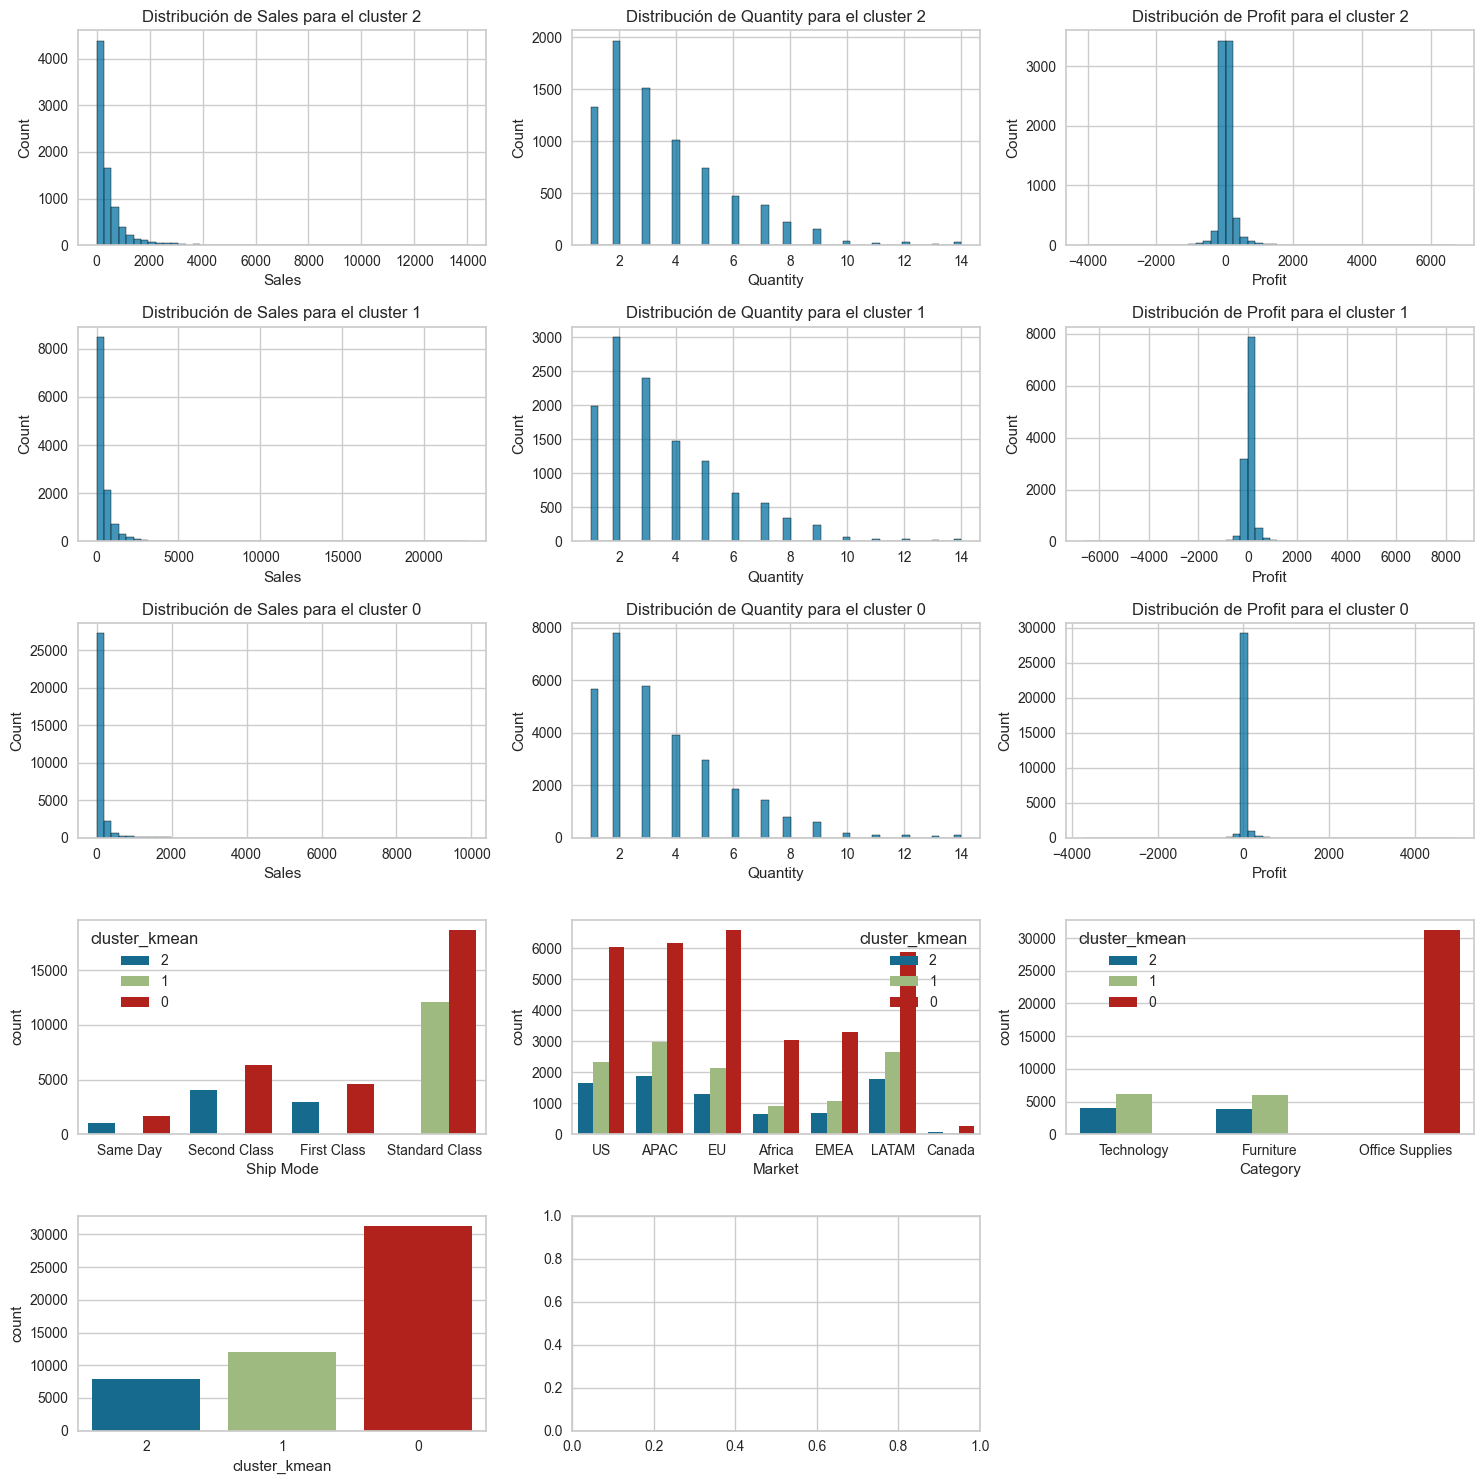

In [43]:
#clust.plot_clusters()
clust.show_cols_clusters(df_inicial, "cluster_kmean")

In [46]:
for cluster in sorted(df_inicial["cluster_kmean"].unique()):
    print(f"Cluster {cluster}:")
    display(df_inicial[df_inicial["cluster_kmean"]==f"{cluster}"].describe().T)

Cluster 0:


,count,mean,std,min,25%,50%,75%,max
Sales,31273.0,121.097120,299.321405,0.4440,20.34,46.3800,105.24,9892.74
Quantity,31273.0,3.459278,2.288316,1.0000,2.00,3.0000,5.00,14.00
Profit,31273.0,16.578961,109.749251,-3701.8928,0.45,6.5538,20.58,4946.37


Cluster 1:


,count,mean,std,min,25%,50%,75%,max
Sales,12086.0,442.394741,648.520796,1.584,103.777500,245.9550,529.12242,22638.480
Quantity,12086.0,3.502730,2.258829,1.000,2.000000,3.0000,5.00000,14.000
Profit,12086.0,48.266096,236.781019,-6599.978,-5.422825,21.9945,83.21992,8399.976


Cluster 2:


,count,mean,std,min,25%,50%,75%,max
Sales,7931.0,442.396778,619.971239,0.990,102.681,241.89,532.6100,13999.9600
Quantity,7931.0,3.504728,2.270891,1.000,2.000,3.00,5.0000,14.0000
Profit,7931.0,46.102562,249.356791,-4088.376,-5.372,21.72,85.1788,6719.9808


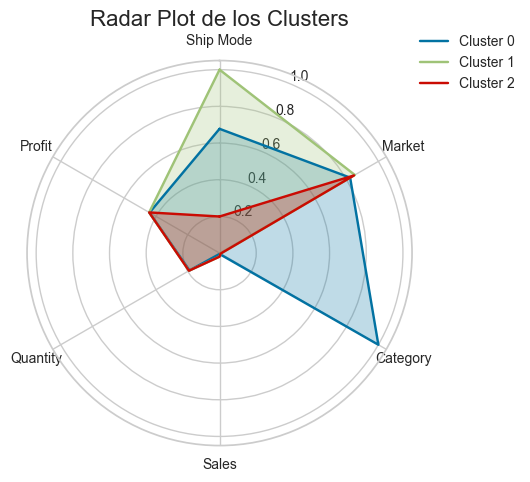

In [47]:
clust.radar_plot("kmeans", figsize=(5, 5))

# **Aglomerativo**

In [ ]:
cluster = sc.Clustering(df)

In [ ]:
df_aglomerativo = cluster.modelo_aglomerativo(clusters_min=2, clusters_max=5, linkage_methods = ['single', 'complete'], distance_metrics = ['euclidean'])

  0%|          | 0/3 [00:00<?, ?it/s]

Estoy ejecutando single con euclidean y 2 clusters


 33%|███▎      | 1/3 [00:53<01:46, 53.31s/it]

Estoy ejecutando single con euclidean y 3 clusters


 67%|██████▋   | 2/3 [01:43<00:51, 51.56s/it]

Estoy ejecutando single con euclidean y 4 clusters


  0%|          | 0/3 [00:00<?, ?it/s]

Estoy ejecutando complete con euclidean y 2 clusters


 33%|███▎      | 1/3 [09:10<18:21, 550.54s/it]

Estoy ejecutando complete con euclidean y 3 clusters


 67%|██████▋   | 2/3 [18:43<09:23, 563.75s/it]

Estoy ejecutando complete con euclidean y 4 clusters


100%|██████████| 3/3 [30:03<00:00, 601.33s/it]


In [35]:
df_aglomerativo

,linkage,metric,silhouette_score,davies_bouldin_index,cluster_cardinality,n_cluster
1,single,euclidean,0.502276,0.883333,"{0: 10141, 1: 9876, 2: 31273}",3
4,complete,euclidean,0.502276,0.883333,"{0: 10141, 1: 31273, 2: 9876}",3
5,complete,euclidean,0.474280,1.012096,"{0: 31273, 1: 10039, 2: 9876, 3: 102}",4
2,single,euclidean,0.474280,1.012096,"{0: 9876, 1: 102, 2: 31273, 3: 10039}",4
3,complete,euclidean,0.355517,1.142095,"{0: 41149, 1: 10141}",2
0,single,euclidean,0.352957,1.155943,"{0: 41414, 1: 9876}",2


In [38]:
df_aglomerativo_2 = cluster.modelo_aglomerativo(clusters_min=2, clusters_max=5, linkage_methods = ['ward'], distance_metrics = ['euclidean'])

  0%|          | 0/3 [00:00<?, ?it/s]

Estoy ejecutando ward con euclidean y 2 clusters


 33%|███▎      | 1/3 [17:07<34:15, 1027.69s/it]

Estoy ejecutando ward con euclidean y 3 clusters


 67%|██████▋   | 2/3 [31:59<15:47, 947.96s/it] 

Estoy ejecutando ward con euclidean y 4 clusters


100%|██████████| 3/3 [40:23<00:00, 807.76s/it]


In [39]:
df_aglomerativo_2

,linkage,metric,silhouette_score,davies_bouldin_index,cluster_cardinality,n_cluster
1,ward,euclidean,0.497427,0.888377,"{0: 31489, 1: 9762, 2: 10039}",3
0,ward,euclidean,0.401244,1.298281,"{0: 19801, 1: 31489}",2
2,ward,euclidean,0.390381,1.124202,"{0: 19467, 1: 12022, 2: 10039, 3: 9762}",4


# **DBSCAN**

In [48]:
df = pd.read_pickle("../datos/df_clustering_encoded_scaled.pkl")
df_inicial = pd.read_pickle("../datos/df_inicial.pkl")

df.head()

,Ship Mode,Market,Category,Sales,Quantity,Profit
0,0.000000,0.905067,0.012385,0.102006,0.461538,0.490812
1,0.270998,1.000000,0.000000,0.163837,0.615385,0.420749
2,0.171119,1.000000,0.012385,0.228586,0.615385,0.501331
3,0.171119,0.905632,0.012385,0.127753,0.307692,0.433564
4,0.000000,0.395837,0.012385,0.125122,0.538462,0.460768


In [49]:
cluster = sc.Clustering(df)

In [50]:
df_cluster_dbscan = cluster.modelo_dbscan(df, eps_values=[1.0], min_samples_values=[2000])

100%|██████████| 1/1 [01:00<00:00, 60.13s/it]

Todos los puntos son ruido o están en el mismo cluster


In [143]:
df_cluster_dbscan = cluster.modelo_dbscan(df, eps_values=[1.0], min_samples_values=[1000])

Todos los puntos son ruido o están en el mismo cluster


In [51]:
df_cluster_dbscan = cluster.modelo_dbscan(df, eps_values=[0.5, 1.0, 1.5, 2.0], min_samples_values=[500, 1000, 2000, 5000, 10000])

100%|██████████| 5/5 [19:56<00:00, 239.25s/it]


,eps,min_samples,silhouette_score,davies_bouldin_score,cardinality,num_clusters
1,0.5,1000,0.630511,1.131188,"{-1: 4, 0: 7930, 1: 12084, 2: 18689, 3: 12583}",5
0,0.5,500,0.630415,0.627358,"{-1: 2, 0: 7931, 1: 12084, 2: 18689, 3: 12584}",5
2,0.5,2000,0.630068,0.856691,"{-1: 38, 0: 7920, 1: 12074, 2: 18688, 3: 12570}",5
3,0.5,5000,0.613790,0.779169,"{-1: 781, 0: 7230, 1: 12064, 2: 18667, 3: 12548}",5
4,0.5,10000,0.569574,0.812956,"{-1: 10588, 0: 11082, 1: 18641, 2: 10979}",4


best_eps: 0.5, best_min_samples: 1000


In [57]:
df_cluster_dbscan = cluster.modelo_dbscan(df, eps_values=[0.5], min_samples_values=[10000])

AttributeError: 'numpy.int64' object has no attribute 'modelo_dbscan'

In [53]:
df_inicial["clusters_dbscan"]=df_cluster_dbscan["clusters_dbscan"]
df_inicial.head()

,Ship Mode,Market,Category,Sales,Quantity,Profit,clusters_dbscan
0,Same Day,US,Technology,2309.650,7,762.1845,0
1,Second Class,APAC,Furniture,3709.395,9,-288.7650,0
2,First Class,APAC,Technology,5175.171,9,919.9710,0
3,First Class,EU,Technology,2892.510,5,-96.5400,0
4,Same Day,Africa,Technology,2832.960,8,311.5200,0


columna: Ship Mode
columna: Market
columna: Category


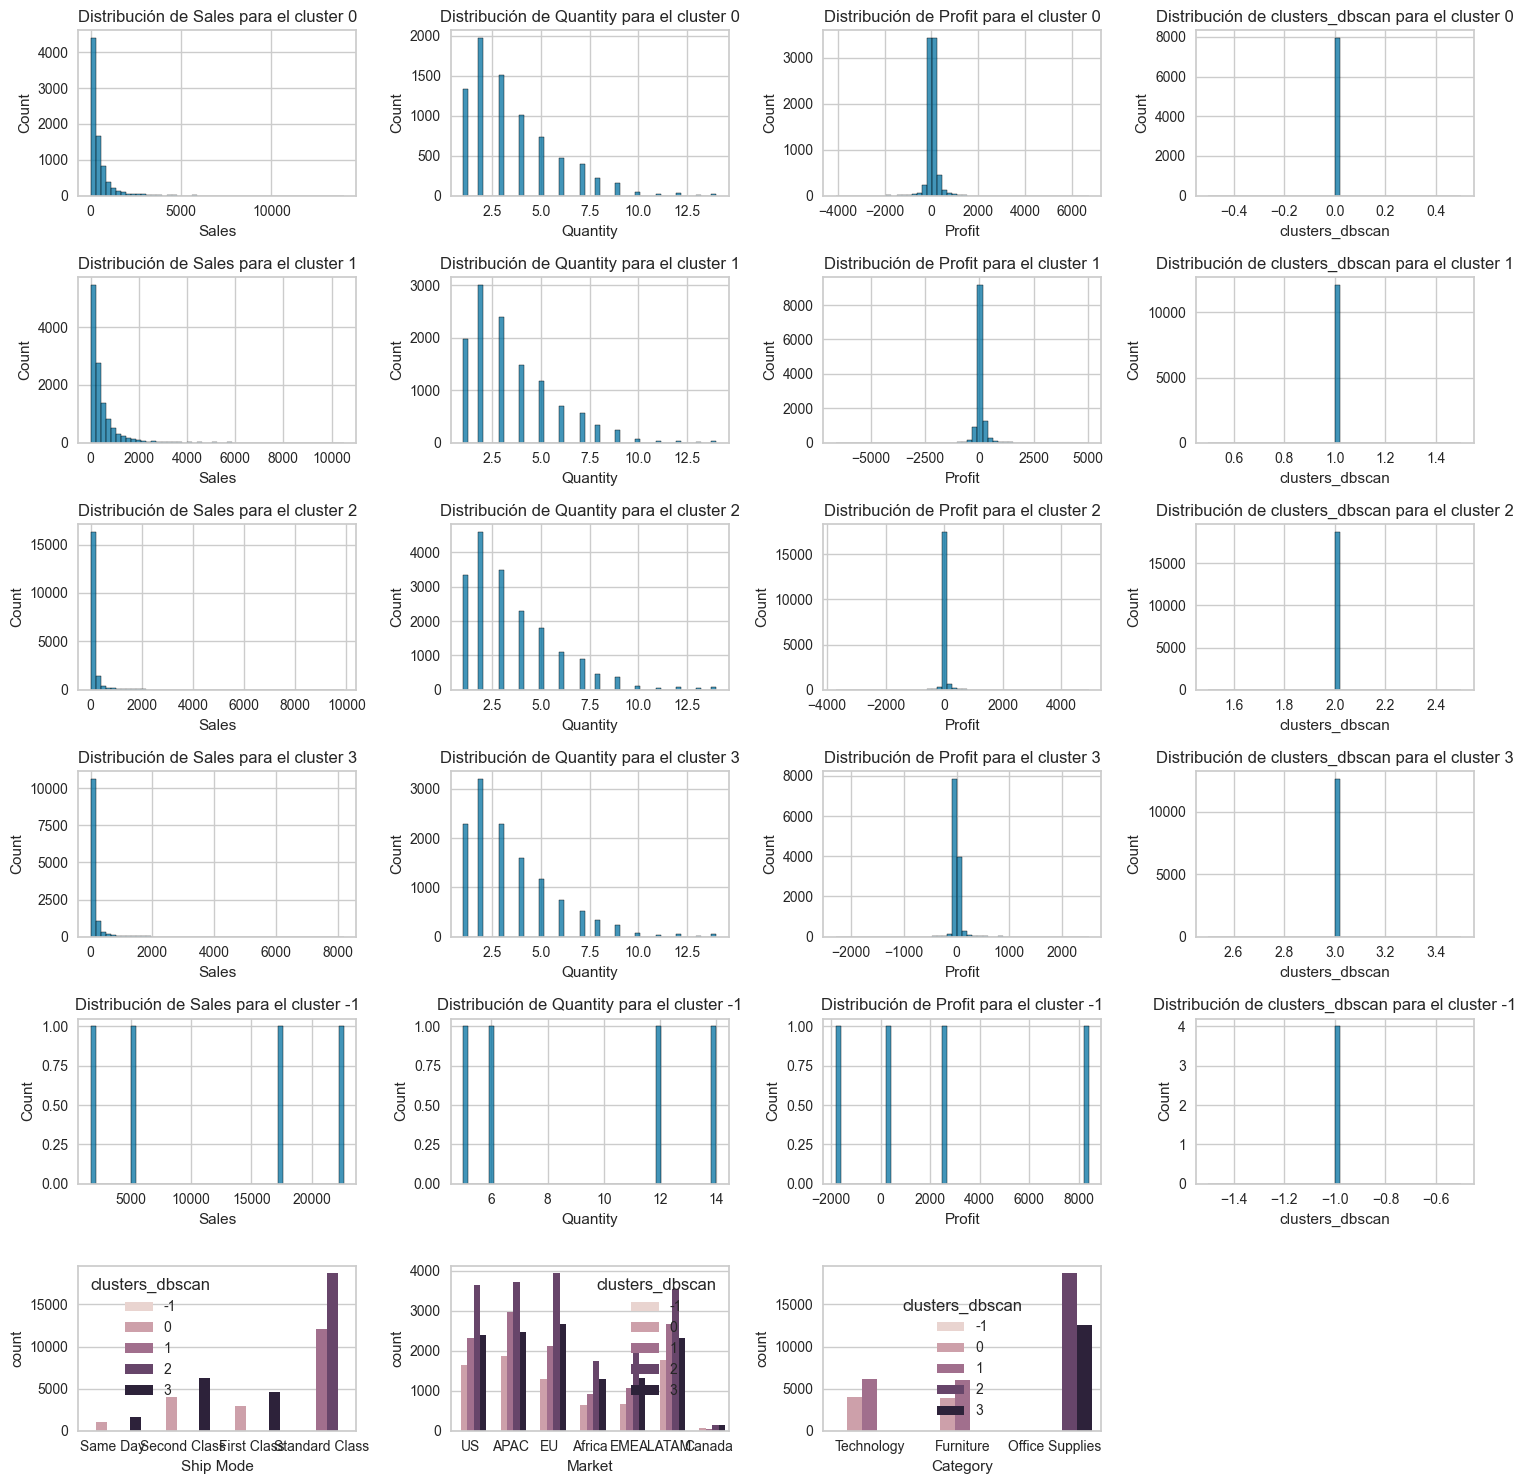

In [54]:
cluster.show_cols_clusters(df_inicial, "clusters_dbscan")

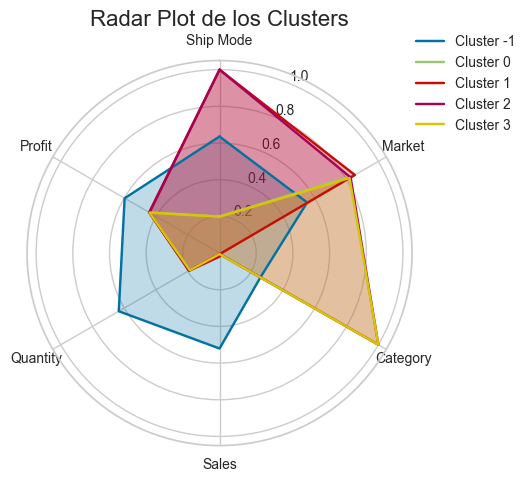

In [55]:
cluster.radar_plot("dbscan", df=df_cluster_dbscan, figsize=(5, 5))

In [ ]:
for clus in sorted(df_inicial["clusters_dbscan"].unique()):
    print(f"Cluster {clus}:")
    display(df_inicial[df_inicial["clusters_dbscan"]==clus].describe().T)

Cluster -1:


,count,mean,std,min,25%,50%,75%,max
Sales,4.0,11786.1575,9901.262990,1704.9600,4402.1700,11400.595,18784.5825,22638.480
Quantity,4.0,9.2500,4.425306,5.0000,5.7500,9.000,12.5000,14.000
Profit,4.0,2364.6744,4408.060505,-1811.0784,-248.3796,1434.900,4047.9540,8399.976
clusters_dbscan,4.0,-1.0000,0.000000,-1.0000,-1.0000,-1.000,-1.0000,-1.000


Cluster 0:


,count,mean,std,min,25%,50%,75%,max
Sales,7930.0,441.784061,617.604216,0.990,102.6315,241.815,532.270,13999.9600
Quantity,7930.0,3.503405,2.267973,1.000,2.0000,3.000,5.000,14.0000
Profit,7930.0,45.780849,247.721011,-4088.376,-5.3880,21.720,85.152,6719.9808
clusters_dbscan,7930.0,0.000000,0.000000,0.000,0.0000,0.000,0.000,0.0000


Cluster 1:


,count,mean,std,min,25%,50%,75%,max
Sales,12084.0,439.146343,596.476870,1.584,103.770000,245.9100,528.92775,10499.9700
Quantity,12084.0,3.502400,2.258861,1.000,2.000000,3.0000,5.00000,14.0000
Profit,12084.0,47.728827,223.641374,-6599.978,-5.386275,21.9945,83.21992,5039.9856
clusters_dbscan,12084.0,1.000000,0.000000,1.000,1.000000,1.0000,1.00000,1.0000


Cluster 2:


,count,mean,std,min,25%,50%,75%,max
Sales,18689.0,119.421546,292.399990,0.4440,20.208,46.0800,105.52,9892.74
Quantity,18689.0,3.477179,2.297218,1.0000,2.000,3.0000,5.00,14.00
Profit,18689.0,16.440258,114.239908,-3701.8928,0.460,6.6312,20.58,4946.37
clusters_dbscan,18689.0,2.000000,0.000000,2.0000,2.000,2.0000,2.00,2.00


Cluster 3:


,count,mean,std,min,25%,50%,75%,max
Sales,12583.0,123.459906,309.000834,0.556,20.4600,46.80,104.8632,8187.6500
Quantity,12583.0,3.432011,2.273670,1.000,2.0000,3.00,5.0000,14.0000
Profit,12583.0,16.764630,102.701244,-2287.782,0.4197,6.42,20.5800,2504.2216
clusters_dbscan,12583.0,3.000000,0.000000,3.000,3.0000,3.00,3.0000,3.0000
